In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.2.4
Sklearn  0.24.2


### Importing Dataset

In [ ]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "umutakta"
    os.environ['KAGGLE_KEY']      = "a471e5474add8d57cadac3cc5ff2b1d6"  
    !pip install --upgrade kaggle
    !kaggle competitions download -c competitive-data-science-predict-future-sales
    DATA_PATH = "/work/Strive_School/Feature_Engineering_(Module_4)/Day_6_Feature_Selection/competitive-data-science-predict-future-sales/"

else:
    DATA_PATH = "/work/competitive-data-science-predict-future-sales/"

DATA_PATH

'/work/competitive-data-science-predict-future-sales/'

**Creating Data Frame**

In [ ]:
df_item_categ=pd.read_csv(DATA_PATH+"item_categories.csv")
df_items=pd.read_csv(DATA_PATH+"items.csv")
df=pd.read_csv(DATA_PATH+"sales_train.csv")
df_sample=pd.read_csv(DATA_PATH+"sample_submission.csv")
df_shops=pd.read_csv(DATA_PATH+"shops.csv")
df_test=pd.read_csv(DATA_PATH+"test.csv")

In [ ]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Turning date column to **date type**

In [ ]:
from datetime import datetime

df["date"]=df['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))


### Deleting Outliers

**Item Count Day**

In [ ]:
df=df.drop(df.loc[df.item_cnt_day<0].index.tolist())

<AxesSubplot:xlabel='item_cnt_day'>

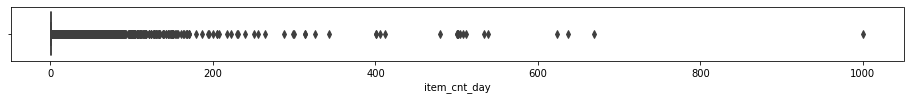

In [ ]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_cnt_day)

**Item Price**

In [ ]:
for i in range(5):
    df=df.drop(df.index[df.loc[df.item_price==df.item_price.max()].index[0]])

<AxesSubplot:xlabel='item_price'>

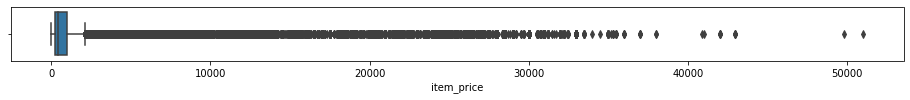

In [ ]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_price)

**Creating new data frame for only 2013**

In [ ]:
df_2013=df[(df.date<"01-01-2014") & ("31-12-2012"<df.date)]
df_2013

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
1267557,2013-12-06,11,46,5671,2690.00,1.0
1267558,2013-12-01,11,46,5671,2590.00,3.0
1267559,2013-12-26,11,46,5669,2690.00,2.0
1267560,2013-12-25,11,46,5669,2690.00,1.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=796ba814-f632-4502-b0d7-7e2f8f9e546d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>